In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
device = torch.device("cpu")

In [3]:
!ls

2classes		Alexnet_2bottle.ipynb		demo_test
4blackclasses_unbiased	Alexnet_2classes.ipynb		requirements.txt
4classes		Alexnet_4bottle.ipynb
811differnet		Alexnet_4bottle_unbiased.ipynb


In [4]:
!ls 4blackclasses_unbiased

test  train


In [5]:
!ls 4blackclasses_unbiased/train

black  blacktumbler  silver  white


In [7]:
!ls 4classes/test

black  blacktumbler  silver  white


In [8]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]) 

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

training_dataset = datasets.ImageFolder('2classes/train', transform = transform_train)
test_dataset = datasets.ImageFolder('2classes/test', transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [9]:
print("train_len:", len(training_dataset))
print("test_len:", len(test_dataset))

train_len: 150
test_len: 45


In [10]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [11]:
classes = ['black', 'blacktumbler', 'silver', 'white']

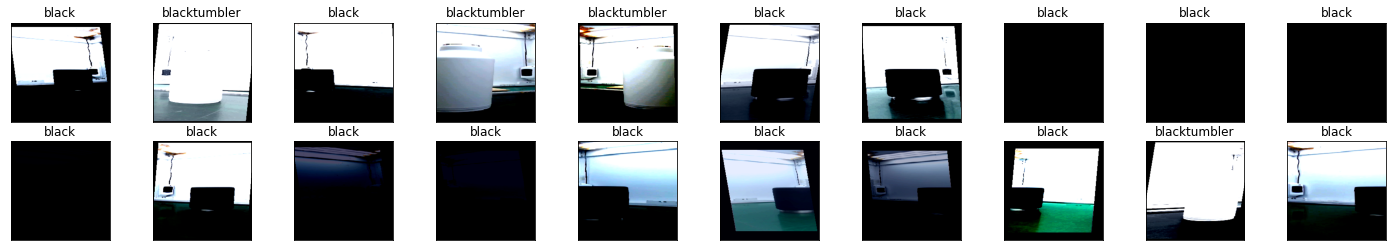

In [12]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [14]:
model = models.alexnet(pretrained=True)

In [15]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

4


In [18]:
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [20]:
epochs = 10
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)
      test_outputs = model(test_inputs)
      test_loss = criterion(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    test_epoch_loss = test_running_loss/len(test_loader.dataset)
    test_epoch_acc = test_running_corrects.float()/ len(test_loader.dataset)
    test_running_loss_history.append(test_epoch_loss)
    test_running_corrects_history.append(test_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('test loss: {:.4f}, test acc{:.4f}'.format(test_epoch_loss, test_epoch_acc.item()))

epoch: 1
training loss: 0.0359, acc0.6933
test loss: 0.0164, test acc0.9556
epoch: 2
training loss: 0.0101, acc0.9267
test loss: 0.0019, test acc1.0000
epoch: 3
training loss: 0.0042, acc0.9800
test loss: 0.0005, test acc1.0000
epoch: 4
training loss: 0.0081, acc0.9467
test loss: 0.0001, test acc1.0000
epoch: 5
training loss: 0.0020, acc0.9933
test loss: 0.0000, test acc1.0000
epoch: 6
training loss: 0.0044, acc0.9667
test loss: 0.0000, test acc1.0000
epoch: 7
training loss: 0.0039, acc0.9600
test loss: 0.0005, test acc1.0000
epoch: 8
training loss: 0.0025, acc0.9800
test loss: 0.0000, test acc1.0000
epoch: 9
training loss: 0.0017, acc0.9933
test loss: 0.0000, test acc1.0000
epoch: 10
training loss: 0.0015, acc0.9867
test loss: 0.0000, test acc1.0000


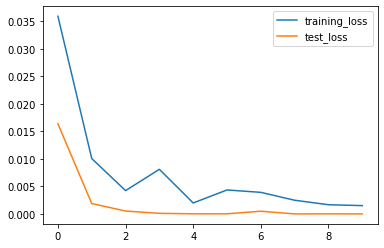

In [21]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(test_running_loss_history, label = "test_loss")
plt.legend()

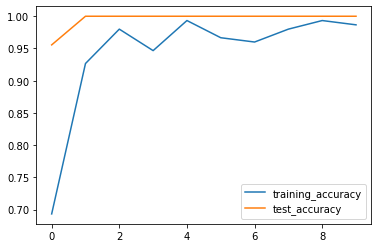

In [22]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(test_running_corrects_history, label = "test_accuracy")
plt.legend()

In [21]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
    Running setup.py install for pillow ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.5.0 requires pillow>=6.2.0, but you'll have pillow 5.2.0 which is incompatible.
You should consider upgrading via the '/home/lihang/chenggui/811test/.env/bin/python3.8 -m pip install --upgrade pip' command.


In [21]:
import PIL.ImageOps

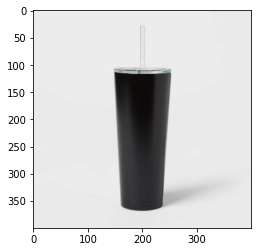

In [23]:
import requests
from PIL import Image

# test an blacktumbler bottle
img1 = Image.open(r'demo_test/1.jpg')
plt.imshow(img1)

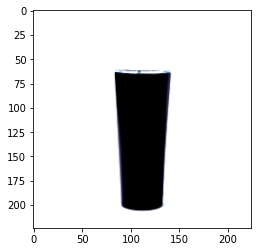

In [24]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [25]:
# Check the predicted type of blacktumbler bottle
image1 = img1.to(device).unsqueeze(0)
output = model(image1)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: Blacktumbler')

Predicted Class: black
Actual Class: Blacktumbler


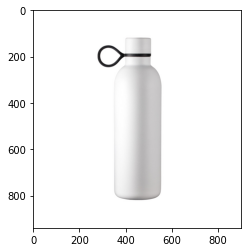

In [26]:
import requests
from PIL import Image

img2 = Image.open(r'demo_test/3.jpg')
plt.imshow(img2)

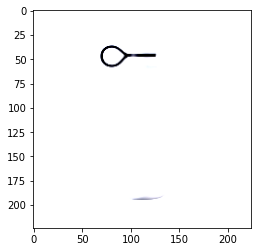

In [27]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [28]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: white')

Predicted Class: blacktumbler
Actual Class: white


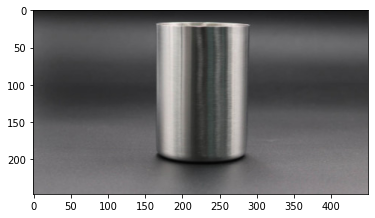

In [30]:
import requests
from PIL import Image

img3 = Image.open(r'demo_test/2.jpg')
plt.imshow(img3)

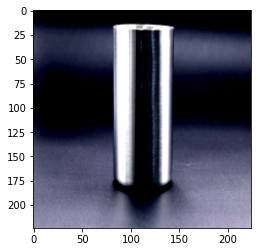

In [31]:
img3 = transform(img3)
plt.imshow(im_convert(img3))

In [32]:
image3 = img3.to(device).unsqueeze(0)
output = model(image3)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: silver')

Predicted Class: black
Actual Class: silver


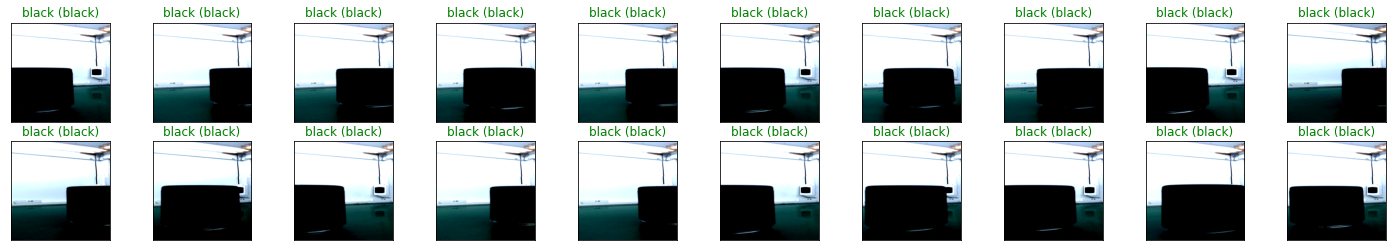

In [35]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
lables = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))

### Accredit
Alexnet Implementation code of this notebook is developed based on the source code of the udemy online course "PyTorch for Deep Learning and Computer Vision" by Rayan Slim, Jad Slim, Amer Sharaf, Sarmad Tanveer.